In [224]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import catboost
import ipywidgets
import os
import ujson as json
from tqdm.notebook import tqdm

### Поехали

Загрузим данные и посмотрим на них

In [2]:
dota_res = pd.read_csv("D:/bioinformatic_institution/ML/kaggle/train_data.csv")
dota_res.head()

,match_id_hash,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
1,6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
2,19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
3,c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,...,8.264696,0,0,3,0,0.25,0,0,3,0
4,156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,...,15.762911,3,1,0,1,0.50,0,0,3,0


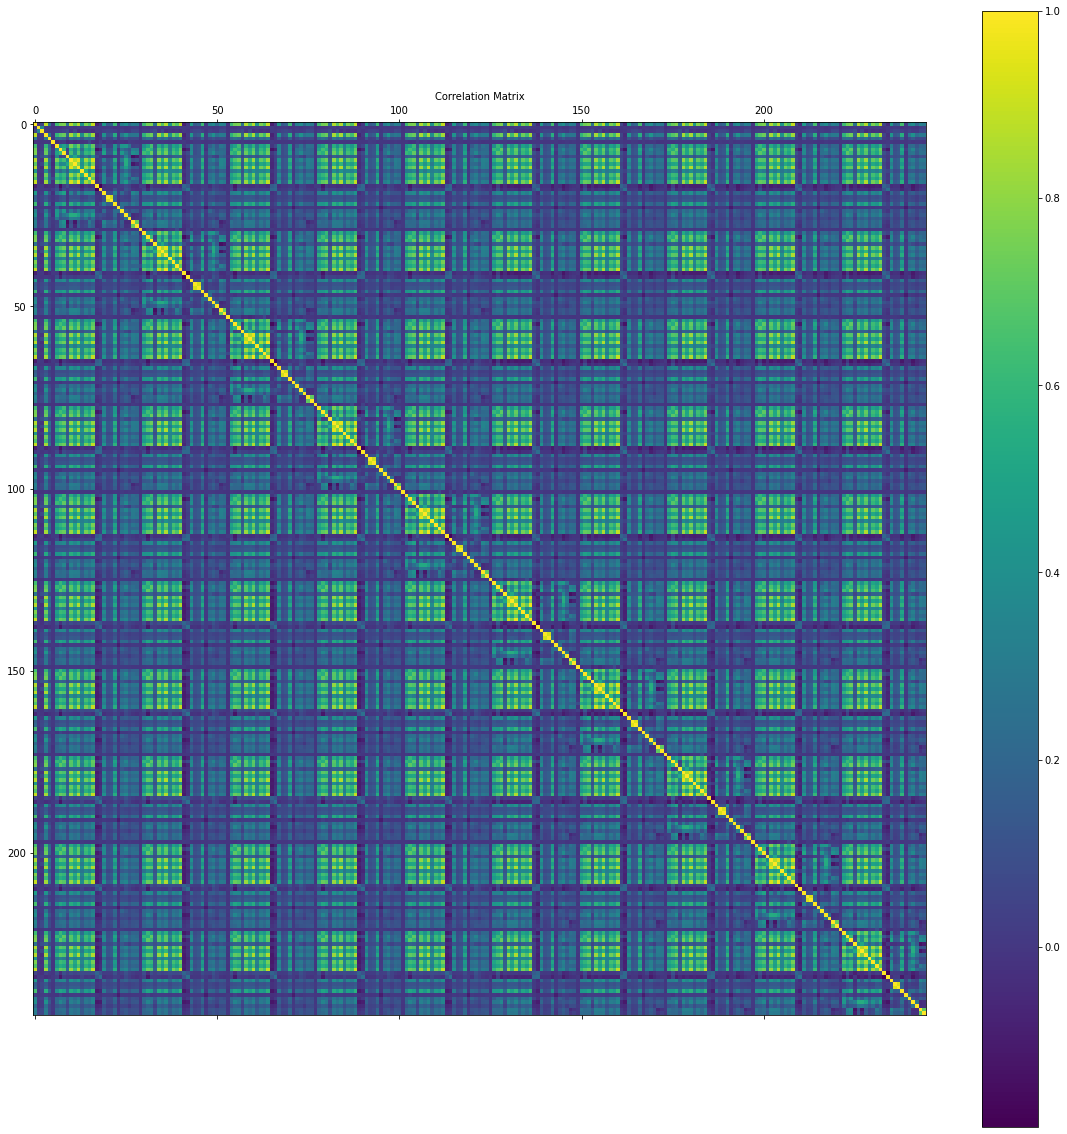

In [5]:
f = plt.figure(figsize=(20, 20))
plt.matshow(dota_res.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

Мы видим, что статистика по каждому игроку, скорее всего, избыточна, так как признаки скоррелированы между игроками. Правильнее будет считать суммарную статистику по всем игрокам. 

In [8]:
dota_res.columns = [c.replace("1", "") for c in list(dota_res.columns)]
dota_res.columns = [c.replace("2", "") for c in list(dota_res.columns)]
dota_res.columns = [c.replace("3", "") for c in list(dota_res.columns)]
dota_res.columns = [c.replace("4", "") for c in list(dota_res.columns)]
dota_res.columns = [c.replace("5", "") for c in list(dota_res.columns)]

In [15]:
total_dota_res = dota_res.groupby(dota_res.columns, axis=1).sum()
total_dota_res.head()

,chat_len,d_assists,d_camps_stacked,d_creeps_stacked,d_deaths,d_denies,d_firstblood_claimed,d_gold,d_health,d_hero_id,...,r_obs_placed,r_roshans_killed,r_rune_pickups,r_sen_placed,r_stuns,r_teamfight_participation,r_towers_killed,r_x,r_xp,r_y
0,10,3,2,3,16,16,1,13144,3310,221,...,4,0,13,3,42.060296,1.875000,1,614,17566,686
1,0,0,0,0,0,0,0,480,3146,189,...,0,0,3,0,0.000000,0.000000,0,580,0,586
2,0,0,0,0,0,5,0,1843,2254,286,...,1,0,7,0,7.231550,0.000000,0,550,2942,692
3,0,13,0,0,10,38,0,20819,4817,365,...,6,0,32,2,63.184530,2.100000,0,610,26116,568
4,2,10,2,6,6,44,1,13418,3127,333,...,2,0,9,0,5.332095,2.166667,0,604,13044,526


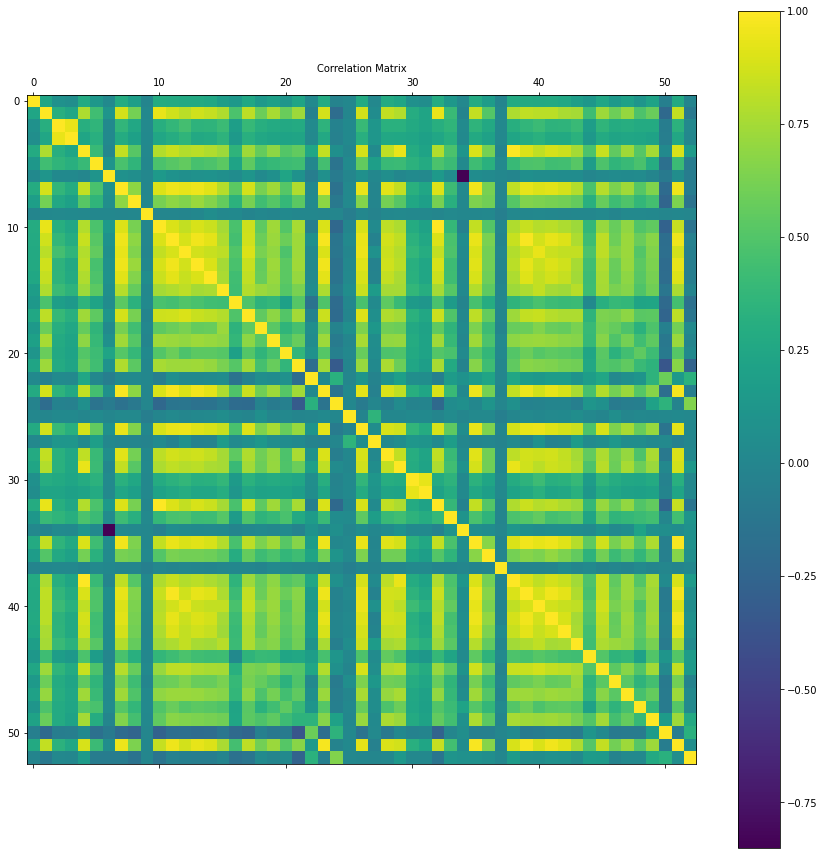

In [17]:
f = plt.figure(figsize=(15, 15))
plt.matshow(total_dota_res.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

Wery nice! Но мы видим, что в наших данных много сильно скоррелированных признаков. Если мы их уберём, т.е. из каждой скоррелированной группы оставим только один, это повысит скорости обчения, а информацию мы практически не потеряем. Поэтому оставим по одному признаку из групп с коефициентами корреляции выше 0.8

In [18]:
corr_matrix = total_dota_res.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
total_dota_res.drop(to_drop, axis=1, inplace=True)
total_dota_res

C:\Users\dmitr\AppData\Local\Temp\ipykernel_15088\3444770072.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,chat_len,d_assists,d_camps_stacked,d_deaths,d_denies,d_firstblood_claimed,d_health,d_hero_id,d_roshans_killed,d_sen_placed,...,r_denies,r_health,r_hero_id,r_roshans_killed,r_sen_placed,r_stuns,r_teamfight_participation,r_towers_killed,r_x,r_y
0,10,3,2,16,16,1,3310,221,0,2,...,28,4498,290,0,3,42.060296,1.875000,1,614,686
1,0,0,0,0,0,0,3146,189,0,0,...,0,3128,298,0,0,0.000000,0.000000,0,580,586
2,0,0,0,0,5,0,2254,286,0,0,...,9,3343,365,0,0,7.231550,0.000000,0,550,692
3,0,13,0,10,38,0,4817,365,0,1,...,33,4873,377,0,2,63.184530,2.100000,0,610,568
4,2,10,2,6,44,1,3127,333,0,1,...,37,3344,316,0,0,5.332095,2.166667,0,604,526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31693,8,86,2,34,30,0,10548,267,2,5,...,40,1794,368,0,0,113.770735,2.903226,2,592,544
31694,5,15,2,28,56,1,9981,265,1,20,...,51,6127,180,1,19,43.044563,2.296296,1,704,658
31695,0,27,0,7,10,1,6143,420,0,0,...,7,3928,208,0,0,47.488480,2.428571,1,600,606
31696,0,1,1,2,26,0,2697,246,0,1,...,12,2420,172,0,2,1.266357,2.500000,0,632,620


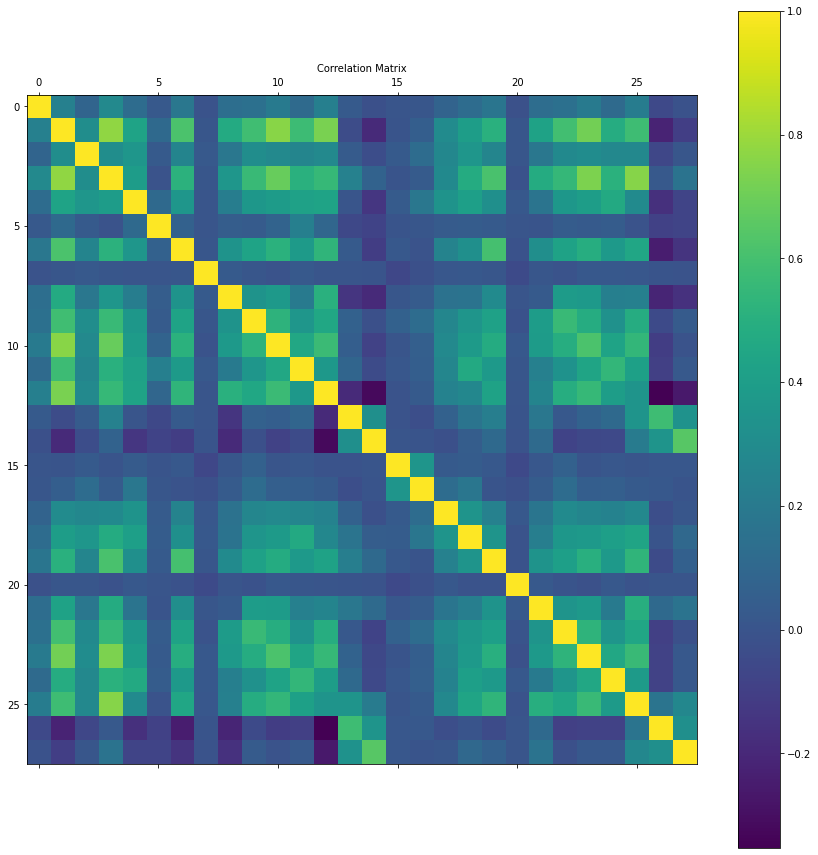

In [19]:
f = plt.figure(figsize=(15, 15))
plt.matshow(total_dota_res.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

Вот так гораздо лучше. Посмотрим, кто у нас остался.

In [20]:
total_dota_res.columns

Index(['chat_len', 'd_assists', 'd_camps_stacked', 'd_deaths', 'd_denies',
       'd_firstblood_claimed', 'd_health', 'd_hero_id', 'd_roshans_killed',
       'd_sen_placed', 'd_stuns', 'd_teamfight_participation',
       'd_towers_killed', 'd_x', 'd_y', 'game_mode', 'lobby_type',
       'match_id_hash', 'r_camps_stacked', 'r_denies', 'r_health', 'r_hero_id',
       'r_roshans_killed', 'r_sen_placed', 'r_stuns',
       'r_teamfight_participation', 'r_towers_killed', 'r_x', 'r_y'],
      dtype='object')

Странно, конечно. Я бы руками оставил другие, но по идее при высокой корреляции не важно, какие оставлять - информация сохраняется. 
Попробуем для начала простой рандомный лес.

In [22]:
train_targets = pd.read_csv("D:/bioinformatic_institution/ML/kaggle/train_targets.csv")
train_targets.head()

,match_id_hash,game_time,radiant_win,duration,time_remaining,next_roshan_team
0,b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
1,6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
2,19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
3,c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
4,156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [ ]:
results = train_targets.radiant_win

In [25]:
X_train, X_test, y_train, y_test = train_test_split(total_dota_res, results)

In [38]:
rfc = RandomForestClassifier()

parameters = {'n_estimators':(100, 200, 300), 'criterion':['gini', 'entropy'], 'max_features':['sqrt', 'log2']}

dota_clf = GridSearchCV(rfc, parameters)

In [40]:
dota_clf.fit(X_train.drop(['match_id_hash'], axis=1), y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': (100, 200, 300)})

In [44]:
y_pred = dota_clf.predict_proba(X_test.drop(['match_id_hash'], axis=1))[:, 1]

In [47]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.7871678661848392

Неплохо. Попробуем теперь на тестовых данных.

In [110]:
data_for_prediction = pd.read_csv("D:/bioinformatic_institution/ML/kaggle/test_data.csv")

In [111]:
data_for_prediction.head()

,match_id_hash,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,...,0.000000,0,0,0,0,0.000,0,0,0,0
1,46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,...,8.664527,3,1,3,0,0.000,0,0,2,0
2,b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,...,0.000000,2,1,2,0,0.250,0,0,0,0
3,ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,...,0.000000,0,0,1,0,0.125,0,0,0,0
4,54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,...,0.766459,0,0,1,0,1.000,0,0,0,0


In [112]:
data_for_prediction.columns = [c.replace("1", "") for c in list(data_for_prediction.columns)]
data_for_prediction.columns = [c.replace("2", "") for c in list(data_for_prediction.columns)]
data_for_prediction.columns = [c.replace("3", "") for c in list(data_for_prediction.columns)]
data_for_prediction.columns = [c.replace("4", "") for c in list(data_for_prediction.columns)]
data_for_prediction.columns = [c.replace("5", "") for c in list(data_for_prediction.columns)]

data_for_prediction = data_for_prediction.groupby(data_for_prediction.columns, axis=1).sum()


data_for_prediction = data_for_prediction[total_dota_res.columns.values.tolist()]

In [113]:
data_for_prediction_id = data_for_prediction['match_id_hash']
data_for_prediction = data_for_prediction.drop(['match_id_hash'], axis = 1)

In [114]:
real_y_pred = dota_clf.predict_proba(data_for_prediction)

In [115]:
data_for_prediction_res = pd.DataFrame(data_for_prediction_id, columns =['match_id_hash'])

In [116]:
data_for_prediction_res['radiant_win_prob'] = real_y_pred[:, 1]

In [94]:
data_for_prediction_res.to_csv("D:/bioinformatic_institution/ML/kaggle/test_data_prediction.csv", index=False)

Получилось 0.79867. Неплохо. Посмотрим, какие параметры оказались самыми важными для дерева.

In [101]:
f_imps = pd.DataFrame(X_train.drop(['match_id_hash'], axis = 1).columns, columns =['variables'])
f_imps['importance'] = dota_clf.best_estimator_.feature_importances_

In [102]:
f_imps

,variables,importance
0,chat_len,0.028192
1,d_assists,0.043513
2,d_camps_stacked,0.017464
3,d_deaths,0.044481
4,d_denies,0.044767
5,d_firstblood_claimed,0.007221
6,d_health,0.055114
7,d_hero_id,0.045113
8,d_roshans_killed,0.004995
9,d_sen_placed,0.021840


Забавно. Самые важные показатели - r_x и r_y. В принципе логично - от одной базы до другой долго идти, если противники часто бывают на чужой базе, они, скорее всего, выиграют)

На всякий случай я попробую запустить рандомный лес на исходных данных и на данных, неочищенных от корреляций, чтобы понять, улучшила что-то подготовка данных или нет (я знаю, что сначала стоило попробовать без подготовки, а потом модифицировать выборку, но очень было интересно поиграть с данными)

In [119]:
dota_raw_res = pd.read_csv("D:/bioinformatic_institution/ML/kaggle/train_data.csv")

In [121]:
raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(dota_raw_res.drop(['match_id_hash'], axis = 1), results)

nocorr_X_train, nocorr_X_test, nocorr_y_train, nocorr_y_test = train_test_split(total_dota_res.drop(['match_id_hash'], axis = 1), results)

parameters = {'n_estimators':[300], 'criterion':['gini', 'entropy'], 'max_features':['sqrt', 'log2']}

In [122]:
raw_dota_clf = GridSearchCV(rfc, parameters)
raw_dota_clf.fit(raw_X_train, raw_y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300]})

In [ ]:
nocorr_dota_clf = GridSearchCV(rfc, parameters)
nocorr_dota_clf.fit(nocorr_X_train, nocorr_y_train)

In [107]:
raw_y_pred = raw_dota_clf.predict_proba(raw_X_test)[:, 1]
nocorr_y_pred = nocorr_dota_clf.predict_proba(nocorr_X_test)[:, 1]
data_for_prediction_res['radiant_win_prob'] = real_y_pred[:, 1]

In [123]:
roc_auc_score(y_true=raw_y_test, y_score=raw_y_pred)

0.4935204016908732

In [125]:
roc_auc_score(y_true=nocorr_y_test, y_score=nocorr_y_pred)

0.503544143004591

Похоже, предобработка данных позволила значительно улучшить roc_auc_score. Теперь попробую улучшить решение, не подгружая новых фич, а, как настоящие дата-саентисты из мемов, используя бустинг на том, что есть.

In [128]:
booster_na_tinkere = GradientBoostingClassifier(max_depth=5)
boost_parameters = {'n_estimators':[300], 'max_depth':[3, 5, 7, 10]}

dota_booster = GridSearchCV(booster_na_tinkere, boost_parameters)

In [130]:
dota_booster.fit(X_train.drop(['match_id_hash'], axis=1), y_train)

GridSearchCV(estimator=GradientBoostingClassifier(max_depth=5),
             param_grid={'max_depth': [3, 5, 7, 10], 'n_estimators': [300]})

In [131]:
y_pred = dota_booster.predict_proba(X_test.drop(['match_id_hash'], axis=1))[:, 1]

In [132]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.7945693273939827

Стало чуть лучше. Это мы тоже закинем в Kaggle

In [134]:
real_y_pred_boost = dota_booster.predict_proba(data_for_prediction)

In [135]:
data_for_prediction_res = pd.DataFrame(data_for_prediction_id, columns =['match_id_hash'])

In [136]:
data_for_prediction_res['radiant_win_prob'] = real_y_pred_boost[:, 1]

In [137]:
data_for_prediction_res.to_csv("D:/bioinformatic_institution/ML/kaggle/test_data_prediction_boost.csv", index=False)

На тестовых данных в kaggle получили 0.80411. Неплохо. Теперь попробуем catboost, который хорошо себя показал на нашем занятии по ML. Сначала подберём гиперпараметры.

In [163]:
dota_cat = catboost.CatBoostClassifier(verbose=0)

random_params = {'learning_rate': [0.001, 0.01, 0.1],
        'depth': [4, 6, 10],
        'min_data_in_leaf': [5, 7, 9],
        'iterations': [1000, 10000]}


randomized_search_result = dota_cat.randomized_search(random_params,
                                                   X=X_train.drop(['match_id_hash'], axis=1),
                                                   y=y_train.astype(int),
                                                   plot=False, verbose=0)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 0.547017249
bestIteration = 999


bestTest = 0.5424939033
bestIteration = 2675


bestTest = 0.547007224
bestIteration = 9999


bestTest = 0.5424939033
bestIteration = 2675


bestTest = 0.5465904828
bestIteration = 9975


bestTest = 0.5525140772
bestIteration = 77


bestTest = 0.5452681496
bestIteration = 457


bestTest = 0.5452681496
bestIteration = 457


bestTest = 0.5988612317
bestIteration = 999


bestTest = 0.5466041218
bestIteration = 998

Training on fold [0/3]

bestTest = 0.5397866747
bestIteration = 2238

Training on fold [1/3]

bestTest = 0.5379894919
bestIteration = 1887

Training on fold [2/3]

bestTest = 0.5439728853
bestIteration = 1876



In [170]:
randomized_search_result['params']

{'min_data_in_leaf': 5, 'depth': 6, 'iterations': 10000, 'learning_rate': 0.01}

А теперь обучим алгоритм с лучшими параметрами.

In [173]:
dota_cat_thebest = catboost.CatBoostClassifier(min_data_in_leaf= 5, depth= 6, iterations= 10000, learning_rate= 0.01, verbose=0)
dota_cat_thebest.fit(X_train.drop(['match_id_hash'], axis=1), y_train.astype(int))

In [174]:
y_pred = dota_cat_thebest.predict(X_test.drop(['match_id_hash'], axis=1))

In [175]:
roc_auc_score(y_true=y_test.astype(int), y_score=y_pred)

0.7112392225245258

Что-то это настолько хуже, чем рандомный лес, что я даже не буду заливать это на kaggle. Странно, на занятии catboost себя хорошо показывал.

Попробуем дополнить наш датасет какими-нибудь параметрами из сырых данных.

In [225]:
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

In [226]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

In [ ]:
df_train_features_extended = pd.read_csv("D:/bioinformatic_institution/ML/kaggle/train_data.csv")

# Добавим новые
add_new_features(df_train_features_extended, 'D:/bioinformatic_institution/ML/kaggle/train_raw_data.jsonl')

  0%|          | 0/31698 [00:00<?, ?it/s]

In [219]:
df_train_features_extended.head()

,match_id_hash,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,b9c57c450ce74a2af79c9ce96fac144d,658.0,4.0,0.0,3.0,10.0,15.0,7.0,2.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,6db558535151ea18ca70a6892197db41,21.0,23.0,0.0,0.0,0.0,101.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,19c39fe2af2b547e48708ca005c6ae74,160.0,22.0,7.0,0.0,0.0,57.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,c96d629dc0c39f0c616d1949938a6ba6,1016.0,22.0,0.0,1.0,0.0,119.0,0.0,3.0,3.0,...,3.0,0.0,0.25,0.0,0.0,3.0,0.0,NaN,NaN,NaN
4,156c88bff4e9c4668b0f53df3d870f1b,582.0,22.0,7.0,2.0,2.0,12.0,3.0,1.0,2.0,...,0.0,1.0,0.50,0.0,0.0,3.0,0.0,NaN,NaN,NaN


Не грузятся у меня признаки. Больше получаса ждал, не получается. Значит, остановимся на 0.8 на kaggle.